In [19]:
import numpy as np

In [20]:
## Common Setup 
def sigmoid(x):
    return 1/(1+ np.exp(-x))

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x) ** 2

In [21]:
class RNNCell:
    def __init__(self,input_dim,hidden_dim,output_dim,seq_len):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.seq_len = seq_len

        # Weight matrices
        self.Wx = np.random.randn(hidden_dim, input_dim)*0.1
        self.Wh = np.random.randn(hidden_dim,hidden_dim)*0.1
        self.Wy = np.random.randn(output_dim,hidden_dim)*0.1
        self.bh = np.zeros((hidden_dim,1))
        self.by = np.zeros((output_dim,1))

    def forward(self,inputs):
        h = np.zeros((self.hidden_dim,1))
        self.inputs = inputs
        self.hs = [h]
        self.outputs = []

        for x in inputs:
            h = tanh(self.Wx @ x + self.Wh @ h + self.bh)
            y = self.Wy @ h + self.by
            self.hs.append(h)
            self.outputs.append(y)
        return self.outputs
    
    def compute_loss(self,targets):
        loss = 0
        for y,t in zip(self.outputs,targets):
            loss += np.sum((y-t)**2)
        return loss/len(targets)
    
    def backward(self,targets,learning_rate=0.01):
        # Initialize gradients
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        dWy = np.zeros_like(self.Wy)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dh_next = np.zeros((self.hidden_dim,1))

        for t in reversed(range(self.seq_len)):
            dy = 2* (self.outputs[t] - targets[t])
            dWy += dy @ self.hs[t+1].T
            dby += dy

            dh = self.Wy.T @ dy + dh_next
            dh_raw = dh * dtanh(self.Wx @ self.inputs[t] + self.Wh @ self.hs[t] + self.bh)
            dbh += dh_raw
            dWx += dh_raw @ self.inputs[t].T
            dWh += dh_raw @ self.hs[t].T
            dh_next = self.Wh.T @ dh_raw

        # Parameter updates
        self.Wx -= learning_rate * dWx
        self.Wh -= learning_rate * dWh
        self.Wy -= learning_rate * dWy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby

In [22]:
np.random.seed(0)
input_dim = 2
hidden_dim = 5
output_dim = 1
seq_len = 4

# Random input and output sequences
X_train = [np.random.randn(input_dim, 1) for _ in range(seq_len)]
Y_train = [np.random.randn(output_dim, 1) for _ in range(seq_len)]

# Initialize and train RNN
rnn = RNNCell(input_dim, hidden_dim, output_dim, seq_len)

losses = []
for epoch in range(1000):
    outputs = rnn.forward(X_train)
    loss = rnn.compute_loss(Y_train)
    losses.append(loss)
    rnn.backward(Y_train, learning_rate=0.01)

print("Loss Values:", losses)

Loss Values: [0.5972578050050518, 0.5523057494987835, 0.5158928815421591, 0.48629300221573457, 0.46217191275559655, 0.44247999330850557, 0.42638043296752265, 0.4131995888306014, 0.40239151725133737, 0.39351184996253763, 0.3861980110649171, 0.3801538646474191, 0.3751375539157766, 0.370951711272124, 0.36743548288250394, 0.3644579794310553, 0.3619128729059399, 0.3597139298262799, 0.35779131842043876, 0.35608855977204706, 0.35456001637595297, 0.35316882926671866, 0.35188522892283, 0.3506851567022807, 0.3495491433211194, 0.34846139924788444, 0.34740907909537033, 0.3463816883045594, 0.3453706057501118, 0.344368700449376, 0.34337002441525705, 0.3423695669399455, 0.3413630583094234, 0.3403468132007258, 0.3393176058721221, 0.3382725707812006, 0.337209123510937, 0.3361248978960818, 0.33501769606197174, 0.33388544874952264, 0.33272618383261365, 0.33153800136147393, 0.3303190538080212, 0.32906753046281284, 0.327781645151803, 0.3264596266153842, 0.325099711031091, 0.3237001362720088, 0.322259137581

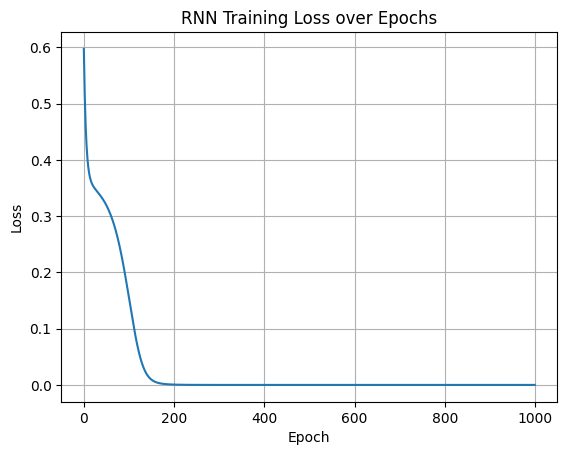

In [23]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN Training Loss over Epochs")
plt.grid(True)
plt.show()

In [24]:
class GRUCell:
    def __init__(self,input_dim,hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Update gate
        self.Wz = np.random.randn(hidden_dim,input_dim)
        self.Uz = np.random.randn(hidden_dim,hidden_dim)
        self.bz = np.zeros((hidden_dim,1))

        # Reset Gate
        self.Wr = np.random.randn(hidden_dim,input_dim)
        self.Ur = np.random.randn(hidden_dim,hidden_dim)
        self.br = np.zeros((hidden_dim,1))

        # Candidate cell state
        self.Wh = np.random.randn(hidden_dim,input_dim)
        self.Uh = np.random.randn(hidden_dim,hidden_dim)
        self.bh = np.zeros((hidden_dim,1))

    def forward(self,x_t,h_prev):
        z_t = sigmoid(self.Wz @ x_t + self.Uz @ h_prev + self.bz)
        r_t = sigmoid(self.Wr @ x_t + self.Ur @ h_prev + self.br)
        h_hat = tanh(self.Wh @ x_t + self.Uh @ (r_t*h_prev) + self.bh)
        h_t = (1-z_t)*h_prev + z_t*h_hat
        return h_t

In [25]:
class LSTMCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Forget gate
        self.Wf = np.random.randn(hidden_dim, input_dim)
        self.Uf = np.random.randn(hidden_dim, hidden_dim)
        self.bf = np.zeros((hidden_dim, 1))

        # Input gate
        self.Wi = np.random.randn(hidden_dim, input_dim)
        self.Ui = np.random.randn(hidden_dim, hidden_dim)
        self.bi = np.zeros((hidden_dim, 1))

        # Candidate Modulation gate
        self.Wg = np.random.randn(hidden_dim, input_dim)
        self.Ug = np.random.randn(hidden_dim, hidden_dim)
        self.bg = np.zeros((hidden_dim, 1))

        # Output gate
        self.Wo = np.random.randn(hidden_dim, input_dim)
        self.Uo = np.random.randn(hidden_dim, hidden_dim)
        self.bo = np.zeros((hidden_dim, 1))

    def forward(self,x_t,h_prev,c_prev):
        f_t = sigmoid(self.Wf @ x_t + self.Uf @ h_prev + self.bf)
        i_t = sigmoid(self.Wi @ x_t + self.Ui @ h_prev + self.bi)
        o_t = sigmoid(self.Wo @ x_t + self.Uo @ h_prev + self.bo)
        g_t = tanh(self.Wg @ x_t + self.Ug @ h_prev + self.bg)
        c_t = f_t*c_prev + i_t*g_t
        h_t = o_t * tanh(c_t)
        return h_t,c_t

In [27]:
# ====== Simulate Input Sequence ======
np.random.seed(42)
seq_len = 5
input_dim = 3
hidden_dim = 4

# Generate a sequence of 5 random input vectors (each of shape 3x1)
X = [np.random.randn(input_dim, 1) for _ in range(seq_len)]

# ====== Run GRU ======
print("\n🔁 GRU Cell Output:")
gru = GRUCell(input_dim, hidden_dim)
h = np.zeros((hidden_dim, 1))
for t, x in enumerate(X):
    h = gru.forward(x, h)
    print(f"t={t}, h={h.ravel()}")

# ====== Run LSTM ======
print("\n🔒 LSTM Cell Output:")
lstm = LSTMCell(input_dim, hidden_dim)
h = np.zeros((hidden_dim, 1))
c = np.zeros((hidden_dim, 1))
for t, x in enumerate(X):
    h, c = lstm.forward(x, h, c)
    print(f"t={t}, h={h.ravel()}")



🔁 GRU Cell Output:
t=0, h=[ 0.48765128 -0.58410753 -0.23309637  0.1743524 ]
t=1, h=[ 0.7034695  -0.78190731  0.02335704 -0.11297626]
t=2, h=[ 0.77114229 -0.80722138  0.32915295 -0.38063785]
t=3, h=[ 0.27438615 -0.84264027  0.52780677 -0.65318804]
t=4, h=[-0.84661537 -0.88706507  0.91891187 -0.92113364]

🔒 LSTM Cell Output:
t=0, h=[-0.06979777 -0.06823132 -0.10652402  0.22891167]
t=1, h=[-0.17064449 -0.11588935  0.03108569  0.20912437]
t=2, h=[-0.11024711 -0.08465173  0.02534566  0.13202472]
t=3, h=[-0.26461283 -0.13127034  0.08238689  0.07417377]
t=4, h=[-0.28899449  0.12890603 -0.05624621 -0.15280599]
